<img src="flopylogo.png" style="float: left">

# Problem P4.3 Hubbertville Areal Model

In Problem P4.3 from page 172-173 in Anderson, Woessner and Hunt (2015), we are asked to construct an areal 2D model to assess impacts of pumping.  The town of Hubbertville is planning to expand its water supply by constructing a pumping well in an unconfined gravel aquifer (Fig. P4.3). The well is designed to pump constantly at a rate of 20,000 m3/day. Well construction was halted by the State Fish and Game Service who manage the Green Swamp Conservation area. The agency claimed that pumping would “significantly reduce” groundwater discharge to the swamp and damage waterfowl habitat. The town claimed the fully penetrating river boundary to the north and the groundwater divide located near the center of the valley would prevent any change in flow to the swamp.

Construct a 2D areal steady-state model of the aquifer between the river and swamp for conditions prior to pumping using the information in Fig. P4.3. Represent the river and swamp boundaries as constant head boundaries with head set at 1000 m. The side boundaries are no-flow boundaries. Justify this assignment of boundary conditions. Use a constant nodal spacing of 500 m. Run the model and produce a contour map of heads. Draw the water-table profile in a north-south cross-section and label the simulated groundwater divide between the river and the swamp. Compute the discharge to Green Swamp.

In this notebook, we will work through the problem using MODFLOW and the Python tool set Flopy. Notice how much code is reused from P4.1 because the variable names remained the same.

<img src="P4.3_figure.tiff" style="float: center">

Below is an iPython Notebook that builds a Python MODFLOW model for this problem and plots results. See the Github wiki associated with this Chapter for information on one suggested installation and setup configuration for Python and iPython Notebook.

[Acknowledgements: This tutorial is modeled after example iPython Notebooks developed by Chris Langevin and Joe Hughes for the USGS Spring 2015 Python Training course GW1774]

##Flopy Tutorial 1: Creating the Model
In this example, we will create a simple groundwater flow model by following the tutorial included on the Flopy website.  We will make a few small changes  so that the tutorial works with our file structure.

Visit the tutorial website [here](http://modflowpy.github.io/flopydoc/tutorial1.html "tutorial").

###Setup the Notebook Environment and Import Flopy
Load a few standard libraries, and then load flopy.

In [1]:
%matplotlib inline
import sys
import os
import shutil
import numpy as np
from subprocess import check_output

# Import flopy
import flopy

###Setup a New Directory and Change Paths
For this tutorial, we will work in the 21_FlopyIntro directory, which is located up one folder and over to the Data folder.  We can use some fancy Python tools to help us manage the directory creation.  Note that if you encounter path problems with this workbook, you can stop and then restart the kernel and the paths will be reset.

In [7]:
# Set the name of the path to the model working directory
dirname = "P4-3_Hubbertville"
datapath = os.getcwd()
modelpath = os.path.join(datapath, dirname)
print 'Name of model path: ', modelpath

# Now let's check if this directory exists.  If not, then we will create it.
if os.path.exists(modelpath):
    print 'Model working directory already exists.'
else:
    print 'Creating model working directory.'
    os.mkdir(modelpath)

Name of model path:  /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-3_Hubbertville
Model working directory already exists.


###Define the Model Extent, Grid Resolution, and Characteristics
It is normally good practice to group things that you might want to change into a single code block.  This makes it easier to make changes and rerun the code.

In [3]:
# model domain and grid definition
# for clarity, user entered variables are all caps; python syntax are lower case or mixed case
# In a contrast to P4.1 and P4.2, this is an areal 2D model
LX = 4500.
LY = 11000.   # note that there is an added 500m on the top and bottom to represent the boundary conditions,that leaves an aqufier lenght of 10000 m  
ZTOP = 1030.  # the system is unconfined so set the top above land surface so that the water table never > layer top
ZBOT = 980.
NLAY = 1
NROW = 22
NCOL = 9
DELR = LX / NCOL  # recall that MODFLOW convention is DELR is along a row, thus has items = NCOL; see page XXX in AW&H (2015)
DELC = LY / NROW  # recall that MODFLOW convention is DELC is along a column, thus has items = NROW; see page XXX in AW&H (2015)
DELV = (ZTOP - ZBOT) / NLAY
BOTM = np.linspace(ZTOP, ZBOT, NLAY + 1)
HK = 50.
VKA = 1.
RCH = 0.001
WELLQ = -20000.   #recall MODFLOW convention, negative means pumped out of the model domain (=aquifer)
print "DELR =", DELR, "  DELC =", DELC, '  DELV =', DELV
print "BOTM =", BOTM
print "Recharge =", RCH 
print "Pumping well rate =", WELLQ


DELR = 500.0   DELC = 500.0   DELV = 50.0
BOTM = [ 1030.   980.]
Recharge = 0.001
Pumping well rate = -20000.0


###Create the MODFLOW Model Object
Create a flopy MODFLOW object: [flopy.modflow.Modflow](http://modflowpy.github.io/flopydoc/mf.html).

In [8]:
# Assign name and create modflow model object
modelname = 'P4-3'
exe_name = os.path.join(datapath, 'mf2005')
print 'Model executable: ', exe_name
MF = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws=modelpath)

Model executable:  /Users/rjhunt1/GitHub/Chapter_4_problems-1/mf2005


###Discretization Package
Create a flopy discretization package object: [flopy.modflow.ModflowDis](http://modflowpy.github.io/flopydoc/mfdis.html).

In [9]:
# Create the discretization object
TOP = ZTOP * np.ones((NROW, NCOL),dtype=np.float)

In [10]:
DIS_PACKAGE = flopy.modflow.ModflowDis(MF, NLAY, NROW, NCOL, delr=DELR, delc=DELC,
                               top=TOP, botm=BOTM[1:], laycbd=0)
# print DIS_PACKAGE  #uncomment this on far left to see information about the flopy object

###Basic Package
Create a flopy basic package object: [flopy.modflow.ModflowBas](http://modflowpy.github.io/flopydoc/mfbas.html).

In [11]:
# Variables for the BAS package
IBOUND = np.ones((NLAY, NROW, NCOL), dtype=np.int32)  # all nodes are active (IBOUND = 1)

# make the top of the profile specified head by setting the IBOUND = -1
IBOUND[:, 0, :] = -1  #don't forget arrays are zero-based!
IBOUND[:, -1, :] = -1  #-1 is Python for last in array
print IBOUND

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1]]]


In [12]:
STRT = 1010 * np.ones((NLAY, NROW, NCOL), dtype=np.float32)  # set starting head to 1010 m through out model domain
STRT[:, 0, :] = 1000.       # river stage for setting constant head
STRT[:, -1, :] = 1000.     # wetland stage for setting constant head
print STRT

[[[ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  10

In [13]:
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)
# print BAS_PACKAGE  # uncomment this at far left to see the information about the flopy BAS object

###Layer Property Flow Package
Create a flopy layer property flow package object: [flopy.modflow.ModflowLpf](http://modflowpy.github.io/flopydoc/mflpf.html).

In [14]:
LPF_PACKAGE = flopy.modflow.ModflowLpf(MF, hk=HK, vka=VKA)  # we defined the K and anisotropy at top of file
# print LPF_PACKAGE  # uncomment this at far left to see the information about the flopy LPF object

###Well Package
Create a flopy output control object: [flopy.modflow.ModflowWel](http://modflowpy.github.io/flopydoc/mfwel.html).

In [15]:
WEL_PACKAGE = flopy.modflow.ModflowWel(MF, stress_period_data=[0,6,4,WELLQ])  # remember python 0 index, layer 0 = layer 1 in MF
#print WEL_PACKAGE  # uncomment this at far left to see the information about the flopy WEL object

###Output Control
Create a flopy output control object: [flopy.modflow.ModflowOc](http://modflowpy.github.io/flopydoc/mfoc.html).

In [16]:
OC_PACKAGE = flopy.modflow.ModflowOc(MF)   # we'll use the defaults for the model output
# print OC_PACKAGE  # uncomment this at far left to see the information about the flopy OC object

###Preconditioned Conjugate Gradient Solver
Create a flopy pcg package object: [flopy.modflow.ModflowPcg](http://modflowpy.github.io/flopydoc/mfpcg.html).

In [17]:
PCG_PACKAGE = flopy.modflow.ModflowPcg(MF) # we'll use the defaults for the PCG solver
# print PCG_PACKAGE  # uncomment this at far left to see the information about the flopy PCG object

###Recharge Package
Create a flopy pcg package object: [flopy.modflow.ModflowRch](http://modflowpy.github.io/flopydoc/mfrch.html).

In [18]:
RCH_PACKAGE = flopy.modflow.ModflowRch(MF, rech=RCH)
# print RCH_PACKAGE  # uncomment this at far left to see the information about the flopy RCH object

##Flopy Tutorial 1: Writing the MODFLOW Input Files
Before we create the model input datasets, we can do some directory cleanup to make sure that we don't accidently use old files.

In [19]:
#Before writing input, destroy all files in folder
#This will prevent us from reading old results
print modelpath
modelfiles = os.listdir(modelpath)
print modelfiles

/Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-3_Hubbertville
[]


In [25]:
#Before writing input, destroy all files in folder
#This will prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

In [26]:
#Now write the model input files
MF.write_input()

Yup.  It's that simple, the model datasets are written using a single command (mf.write_input).

Check in the model working directory and verify that the input files have been created.  Or if you might just add another cell, right after this one, that prints a list of all the files in our model directory.  The path we are working in is returned from this next block.

In [28]:
# return current working directory
print "You can check the newly created files in", modelpath


You can check the newly created files in /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-3_Hubbertville


##Flopy Tutorial 1: Running the Model

Flopy has several methods attached to the model object that can be used to run the model.  They are run_model, run_model2, and run_model3.  Here we use run_model3, which will write output to the notebook.

In [29]:
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)


                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P4-3.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/04/22 18:00:47

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/04/22 18:00:47
 Elapsed run time:  0.010 Seconds

  Normal termination of simulation


##Flopy Tutorial 1: Post Processing the Results
To read heads from the MODFLOW binary output file, we can use the [flopy.utils.binaryfile](http://modflowpy.github.io/flopydoc/binaryfile.html) module. Specifically, we can use the HeadFile object from that module to extract head data arrays. 

In [30]:
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

Headfile (P4-3.hds) contains the following list of times:  [1.0]


In [31]:
#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Head statistics
  min:  998.17
  max:  1003.18
  std:  1.11241


Contour Levels:  [  997.    997.5   998.    998.5   999.    999.5  1000.   1000.5  1001.
  1001.5  1002.   1002.5  1003.   1003.5]
Extent of domain:  (250.0, 4250.0, 250.0, 10750.0)


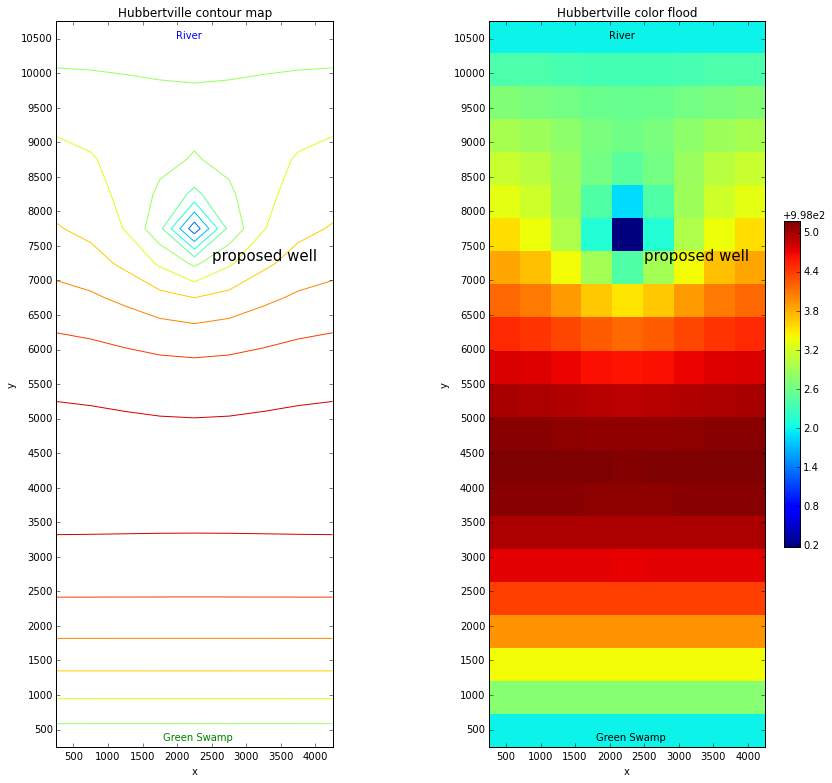

In [32]:
#Create a contour plot of heads
FIG = plt.figure(figsize=(15,13))

#setup contour levels and plot extent
LEVELS = np.arange(997., 1004., 0.5)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)
print 'Contour Levels: ', LEVELS
print 'Extent of domain: ', EXTENT

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 11000, 500)
AX1.set_yticks(YTICKS)
AX1.set_title("Hubbertville contour map")
AX1.text(2500, 7300, r"proposed well", fontsize=15, color="black")
AX1.text(2000, 10500, r"River", fontsize=10, color="blue")
AX1.text(1800, 340, r"Green Swamp", fontsize=10, color="green")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("Hubbertville color flood")
AX2.text(2500, 7300, r"proposed well", fontsize=15, color="black")
AX2.text(2000, 10500, r"River", fontsize=10, color="black")
AX2.text(1800, 340, r"Green Swamp", fontsize=10, color="black")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest')
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)


Look at the bottom of the MODFLOW output file (ending with a *.list) and note the water balance reported. 

In [33]:
#look at the head in column = 4 from headobj, and then plot it
#print HEAD along a column; COL is a variable that allows us to change this easily
COL = 4
print HEAD[0,:,COL]

[ 1000.          1000.33197021  1000.54644775  1000.61340332  1000.46228027
   999.887146     998.17016602  1000.40557861  1001.4989624   1002.16766357
  1002.61688232  1002.91589355  1003.09191895  1003.15692139  1003.11645508
  1002.9732666   1002.7286377   1002.38336182  1001.93768311  1001.39190674
  1000.74597168  1000.        ]


In [34]:
# we see this is what we want, but is flipped because MODFLOW's array does not = Python, so we reverse the order (flip them) and call it 
Y = np.flipud(HEAD[0,:,COL])
print Y

[ 1000.          1000.74597168  1001.39190674  1001.93768311  1002.38336182
  1002.7286377   1002.9732666   1003.11645508  1003.15692139  1003.09191895
  1002.91589355  1002.61688232  1002.16766357  1001.4989624   1000.40557861
   998.17016602   999.887146    1000.46228027  1000.61340332  1000.54644775
  1000.33197021  1000.        ]


In [35]:
#for our cross section create X-coordinates to match with heads
XCOORD = np.arange(0, 11000, 500) + 250
print XCOORD

[  250   750  1250  1750  2250  2750  3250  3750  4250  4750  5250  5750
  6250  6750  7250  7750  8250  8750  9250  9750 10250 10750]


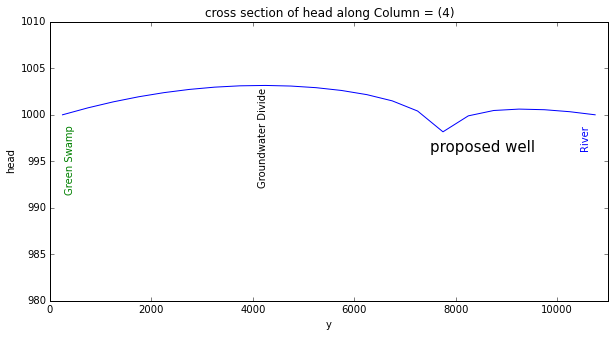

In [36]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  'cross section of head along Column = ({0})'.format(COL)
ax.set_title(TITLE)
ax.set_xlabel('y')
ax.set_ylabel('head')
ax.set_xlim(0, 11000.)
ax.set_ylim(980.,1010.)
ax.text(7500, 996, r"proposed well", fontsize=15, color="black")
ax.text(10480, 998, r"River", fontsize=10, color="blue",rotation='vertical')
ax.text(300, 998, r"Green Swamp", fontsize=10, color="green",rotation='vertical')
ax.text(4100,1002., r"Groundwater Divide", fontsize=10, color="black",rotation='vertical')
ax.plot(XCOORD, Y)

In [37]:
#calculate the flux to Green Swamp
HEAD_ADJACENT_CELLS = HEAD[0,-2,:]
print "heads in cells next to Green Swamp =", HEAD_ADJACENT_CELLS
FLUX_TO_SWAMP = 0
THICK = 1000 - ZBOT   #the thickness is calculated using the height at the exit point at Green Swamp, which is the BC of 1000 m as seen in plot above
for NODEHEAD in HEAD_ADJACENT_CELLS:
    NODEFLUX = (HK * (NODEHEAD-1000.)/(DELC/2) * DELR * THICK) # Q = KIA
    FLUX_TO_SWAMP += NODEFLUX
    print 'gradient =', (NODEHEAD-1000)/(DELC/2), '  Kh =', HK, '  thickness=', THICK, ' Grid spacing =', DELC, ' Node flux =', NODEFLUX
print "Total Flux to Swamp =", FLUX_TO_SWAMP, "cubic meters per day"

heads in cells next to Green Swamp = [ 1000.74609375  1000.74609375  1000.74603271  1000.74597168  1000.74597168
  1000.74597168  1000.74603271  1000.74609375  1000.74609375]
gradient = 0.002984375   Kh = 50.0   thickness= 20.0  Grid spacing = 500.0  Node flux = 1492.1875
gradient = 0.002984375   Kh = 50.0   thickness= 20.0  Grid spacing = 500.0  Node flux = 1492.1875
gradient = 0.00298413085938   Kh = 50.0   thickness= 20.0  Grid spacing = 500.0  Node flux = 1492.06542969
gradient = 0.00298388671875   Kh = 50.0   thickness= 20.0  Grid spacing = 500.0  Node flux = 1491.94335938
gradient = 0.00298388671875   Kh = 50.0   thickness= 20.0  Grid spacing = 500.0  Node flux = 1491.94335938
gradient = 0.00298388671875   Kh = 50.0   thickness= 20.0  Grid spacing = 500.0  Node flux = 1491.94335938
gradient = 0.00298413085938   Kh = 50.0   thickness= 20.0  Grid spacing = 500.0  Node flux = 1492.06542969
gradient = 0.002984375   Kh = 50.0   thickness= 20.0  Grid spacing = 500.0  Node flux = 1492.1

In [38]:
#calculate the flux to River
HEAD_ADJACENT_CELLS = HEAD[0,1,:]
print "heads in cells next to River =", HEAD_ADJACENT_CELLS
FLUX_TO_RIVER = 0
THICK = 1000 - ZBOT   #the thickness is calculated using the height at the exit point at the River, which is the BC of 1000 m as seen in plot above
for NODEHEAD in HEAD_ADJACENT_CELLS:
    NODEFLUX = (HK * (NODEHEAD-1000.)/(DELC/2) * DELR * THICK) # Q = KIA
    FLUX_TO_RIVER += NODEFLUX
    print 'gradient =', (NODEHEAD-1000)/(DELC/2), '  Kh =', HK, '  thickness=', THICK, ' Grid spacing =', DELC, ' Node flux =', NODEFLUX
print "Total Flux to River =", FLUX_TO_RIVER, "cubic meters per day"

heads in cells next to River = [ 1000.3939209   1000.38140869  1000.36077881  1000.34075928  1000.33197021
  1000.34075928  1000.36077881  1000.38140869  1000.3939209 ]
gradient = 0.00157568359375   Kh = 50.0   thickness= 20.0  Grid spacing = 500.0  Node flux = 787.841796875
gradient = 0.00152563476562   Kh = 50.0   thickness= 20.0  Grid spacing = 500.0  Node flux = 762.817382812
gradient = 0.00144311523437   Kh = 50.0   thickness= 20.0  Grid spacing = 500.0  Node flux = 721.557617188
gradient = 0.00136303710938   Kh = 50.0   thickness= 20.0  Grid spacing = 500.0  Node flux = 681.518554688
gradient = 0.00132788085938   Kh = 50.0   thickness= 20.0  Grid spacing = 500.0  Node flux = 663.940429688
gradient = 0.00136303710938   Kh = 50.0   thickness= 20.0  Grid spacing = 500.0  Node flux = 681.518554688
gradient = 0.00144311523437   Kh = 50.0   thickness= 20.0  Grid spacing = 500.0  Node flux = 721.557617188
gradient = 0.00152563476562   Kh = 50.0   thickness= 20.0  Grid spacing = 500.0  N

In [39]:
print 'Flux to Green Swamp =', FLUX_TO_SWAMP, 'Flux to River =', FLUX_TO_RIVER
BCFLUX = FLUX_TO_SWAMP + FLUX_TO_RIVER
Q = WELLQ * -1
print 'Flux to perimeter boundaries =', BCFLUX, ', Well pumping =', Q, ', Total Vol Out =', BCFLUX+Q, 'cubic meters per day'

Flux to Green Swamp = 13428.7109375 Flux to River = 6571.41113281
Flux to perimeter boundaries = 20000.1220703 , Well pumping = 20000.0 , Total Vol Out = 40000.1220703 cubic meters per day


##Testing your Skills

1.  Does the total volumetric flux out equal that reported in the MODFLOW list file?

2.  Experiment with horizontal grid resolution, well location, recharge, pumping rate, and aquifer characteristics.  Rerun the model and post process to evaluate the effects.